# Analisi sui fattori di sopravvivenza dei passeggeri del Titanic

---  
  
Nel seguente report, proveremo ad analizzare i principali fattori di sopravvivenza dei passeggeri del titanic. Il dataset utilizzato è stato fornito da Kaggle nell'ambito di una competizione[^idk] all'addestrare un modello Machine Learning dedicato a predirre la sopravvienza dei passeggeri.  

Il dataset è fornito diviso in due parti: uno dedicato al training del modello, mentre l'altro viene utilizzato per la predizione della consegna finale. In quest'ultimo (nominato *test*), la feature target *Survived* è assente. In seguito, sono descritte le feature del dataset:  
- **PassengerId**: Identificativo univoco del passeggero  
- **Survived**: feature binaria, indica se il passeggero è sopravvissuto o meno
- **Pclass**: Classe del biglietto (1 = prima, 2 = seconda, 3 = terza)  
- **Name**: Nome e titolo del passeggero; per le donne, se sposate, è indicato anche il nome di battesimo  
- **Sex**: Sesso  
- **Age**: Età  
- **SibSp**: Numero di fratelli/coniugi a bordo  
- **Parch**: Numero di genitori/figli a bordo  
- **Ticket**: Identificativo del biglietto  
- **Fare**: Prezzo del biglietto  
- **Cabin**: Cabina assegnata  
- **Embarked**: Porto di imbarco (C = Cherbourg, Q = Queenstown, S = Southampton)

[^idk]: https://www.kaggle.com/competitions/titanic/overview.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve
from xgboost import XGBClassifier

train_df = pd.read_csv('dataset/train.csv')

print(train_df.head(3))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  


### Data Exploration  

---  

Prima di procedere al precrocessing dei dati, eseguiamo una analisi per verificare se sono presenti pattern espliciti.  
Iniziamo a rappresentare la distribuzione di variabili come l'età, la classe di appartenenza, il sesso dei passeggeri.

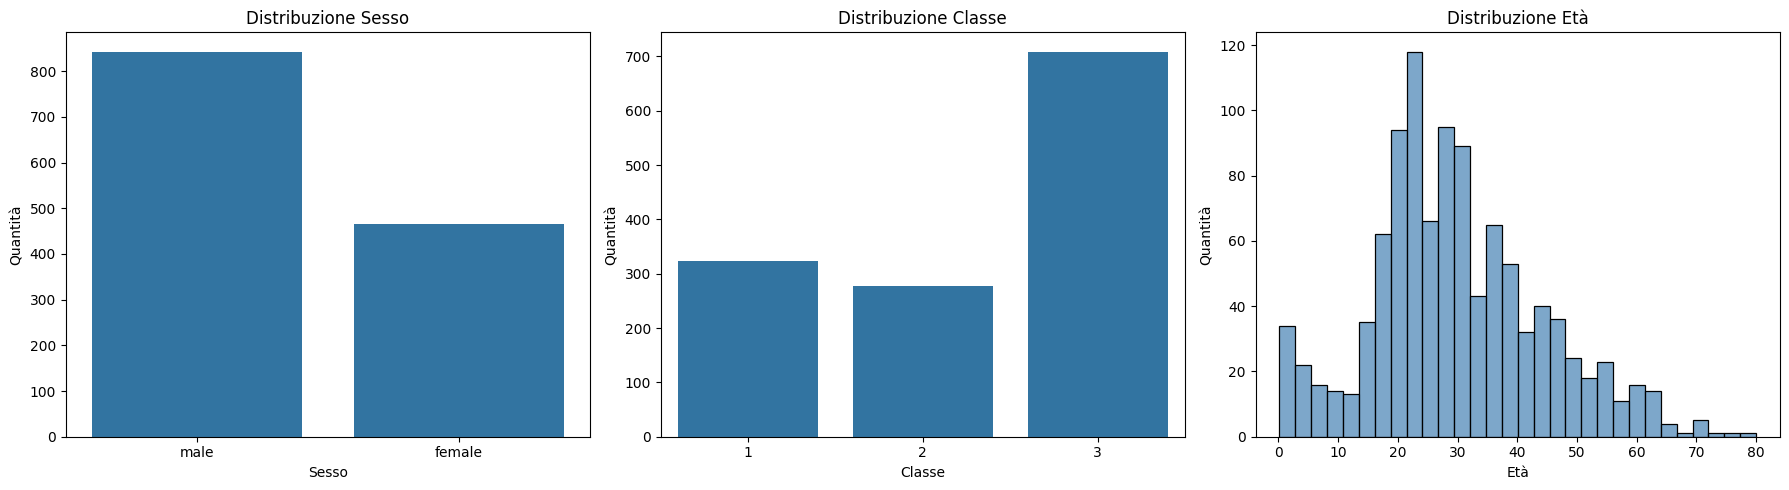

In [ ]:
test_df = pd.read_csv('dataset/test.csv')

df = pd.concat([train_df, test_df], ignore_index=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(x='Sex', data=df, ax=axes[0])
axes[0].set_title('Distribuzione Sesso')
axes[0].set_xlabel('Sesso')
axes[0].set_ylabel('Quantità')


sns.countplot(x='Pclass', data=df, ax=axes[1])
axes[1].set_title('Distribuzione Classe')
axes[1].set_xlabel('Classe')
axes[1].set_ylabel('Quantità')


sns.histplot(df['Age'].dropna(), bins=30, kde=False, ax=axes[2], color='steelblue', alpha=0.7)
axes[2].set_title('Distribuzione Età')
axes[2].set_xlabel('Età')
axes[2].set_ylabel('Quantità')

plt.tight_layout()
plt.show()





Da questi grafici, si può intuire che i passeggeri maschili di terza classe, tra i 18-36 anni, siano una componente significativa del dataset. Verifichiamo l'ipotesi andando a graficare la relazione tra sesso, classe ed età.

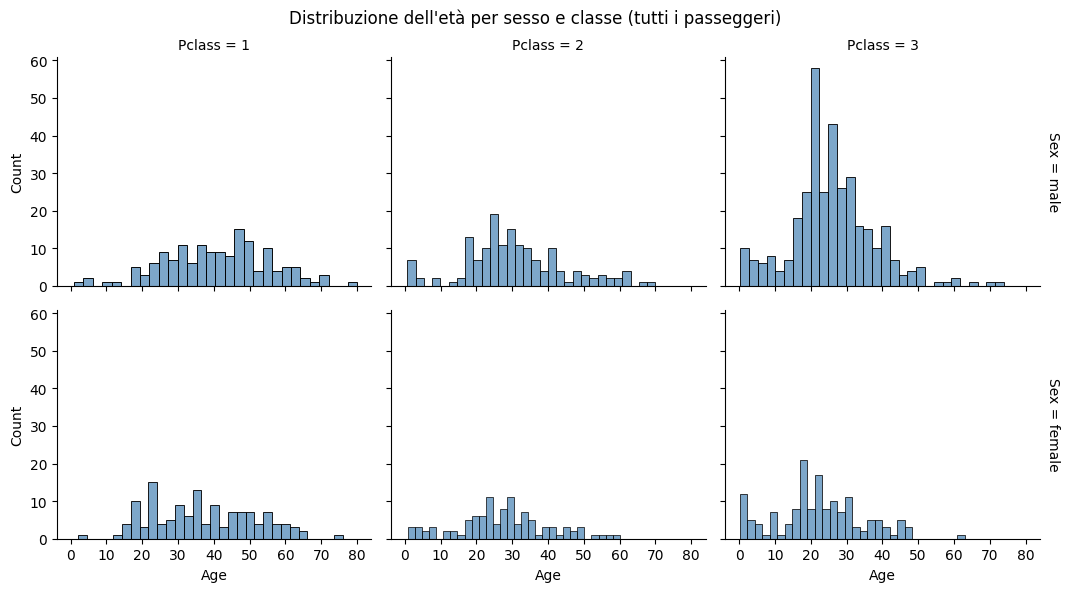

In [ ]:
g = sns.FacetGrid(df, row="Sex", col="Pclass", margin_titles=True, height=3, aspect=1.2)
g.map(sns.histplot, "Age", bins=30, color="steelblue", alpha=0.7, kde=False)
# per avere più tacche sull'asse x
for ax in g.axes.flatten():
    ax.set_xticks(np.arange(0, 85, 10))
plt.subplots_adjust(top=0.9)
g.figure.suptitle("Distribuzione dell'età per sesso e classe (tutti i passeggeri)")
plt.show()

Come abbiamo ipotizzato, i maschi di terza classe sono una componente significativa del nostro dataset. Risulta utile visualizzare anche la distribuzione dei superstiti secondo queste parametri.  
Si noti che il grafico successivo, data l'assenza del campo Survived nel dataset di testing, avrà un numero minore di entry rispetto al grafico di sopra.

C:\Users\Astolfo\AppData\Local\Temp\ipykernel_6976\1882907563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['Survived'] = df_plot['Survived'].map({0: 'Not Survived', 1: 'Survived'})


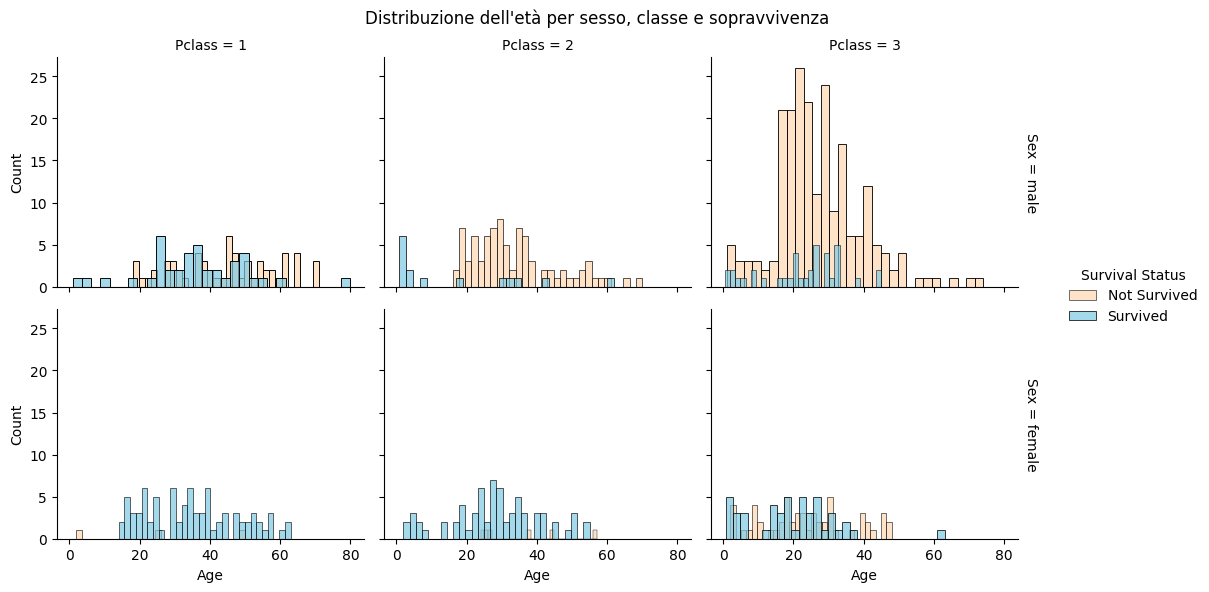

In [ ]:
df_plot = df.dropna(subset=['Survived', 'Age'])
df_plot['Survived'] = df_plot['Survived'].map({0: 'Not Survived', 1: 'Survived'})
survival_palette = {'Survived': '#7ec8e3', 'Not Survived': '#ffd8b1'}
g = sns.FacetGrid(
    df_plot,
    row="Sex",
    col="Pclass",
    hue="Survived",
    margin_titles=True,
    height=3,
    aspect=1.2,
    palette=survival_palette
)
g.map(sns.histplot, "Age", bins=30, alpha=0.7, kde=False)
g.add_legend(title="Survival Status")
plt.subplots_adjust(top=0.9)
g.figure.suptitle("Distribuzione dell'età per sesso, classe e sopravvivenza")
plt.show()

Notiamo che la popolazione femminile abbia un tasso di sopravvivenza maggiore di quella maschile per ogni classe, mentre la popolazione maschile di terza classe è quella con il tasso di sopravvivenza più basso. Rappresentiamo il valore percentuale per rendere più evidente la relazione.

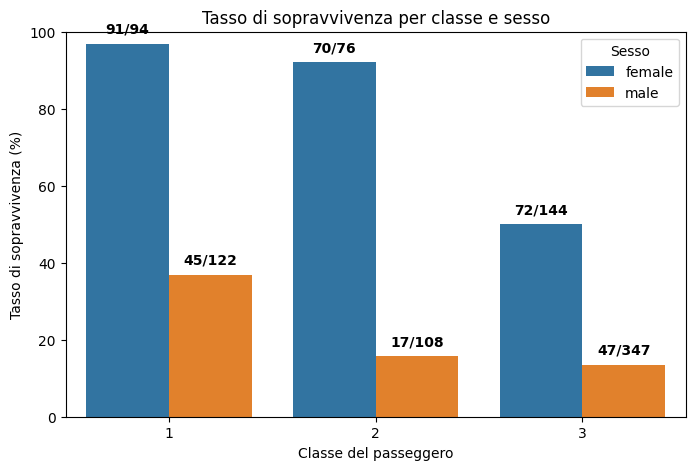

In [45]:
survival_stats = (
    df.dropna(subset=['Survived'])
      .groupby(['Sex', 'Pclass'])['Survived']
      .agg(['mean', 'sum', 'count'])
      .reset_index()
)
survival_stats['SurvivalRate'] = survival_stats['mean'] * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=survival_stats,
    x='Pclass',
    y='SurvivalRate',
    hue='Sex'
)
plt.ylabel('Tasso di sopravvivenza (%)')
plt.xlabel('Classe del passeggero')
plt.title('Tasso di sopravvivenza per classe e sesso')
plt.ylim(0, 100)
plt.legend(title='Sesso')

for bar, (_, group) in zip(ax.patches, survival_stats.iterrows()):
    survivors = int(group['sum'])
    total = int(group['count'])
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 2,
        f"{survivors}/{total}",
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

plt.show()

---  

### Preprocessing

In [25]:
print(df.info())
print(df.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
None
   PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   

                                                Name     Sex   Age  SibSp  \
0             

Trascurando i "Survived" mancanti per le entry del dataset di test, procediamo a risolvere i parametri mancanti.  
Iniziando dalla colonna "Embarked", sono assenti solo due valori per le seguente passeggere:

In [6]:
print(df[df['Embarked'].isna()])

     PassengerId  Survived  Pclass                                       Name  \
61            62       1.0       1                        Icard, Miss. Amelie   
829          830       1.0       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   female  38.0      0      0  113572  80.0   B28      NaN  
829  female  62.0      0      0  113572  80.0   B28      NaN  


Notiamo che le due condividono cabina, identificativo e prezzo del biglietto, il che implica che si siano imbarcate allo stesso porto. Tramite una ricerca, riscontriamo che Amelie Icard era la domestica di Martha Evelyn Stone, ed entrambe si sono imbarcate al porto di Southampton.

In [20]:
df.loc[df['PassengerId'] == 830, 'Embarked'] = 'S'
df.loc[df['PassengerId'] == 62, 'Embarked'] = 'S'

Per la gestione delle età mancanti, è opportuno verificare la presenza di eventuali pattern in base ad altri fattori. Il grafico seguente rappresenta la distribuzione dell'età in base al sesso ed alla classe di appartenenza

Notiamo che ogni classe presenta una distribuzione diversa dell'età: ad esempio, i maschi in terza classe hanno un importante picco tra i 20 e i 30 anni, mentre le femmine della stessa classe hanno un picco tra i 18-24 e sotto i 2 anni.  
Da ciò possiamo dedurre che conviene assegnare l'età in base a questi parametri. In seguito, assegnamo l'età in base al valore mediano del gruppo di appartenenza.

In [21]:
median_ages = df.groupby(['Sex', 'Pclass'])['Age'].median()
df['Age'] = df.apply(
    lambda row: median_ages[row['Sex'], row['Pclass']] if pd.isna(row['Age']) else row['Age'],
    axis=1
)

Passiamo ora alla gestione del Fare. Una singola entry ha il valore mancante, corrispondente ad un maschio di terza classe che viaggia da solo.

In [22]:
print(df[df['Fare'].isna()])

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked]
Index: []


Per assegnargli il fare più opportuno, possiamo ricavare il prezzo mediano di tutti i maschi nella sue stesse circostanze, ovvero passeggeri di terza classe solitari.

In [24]:
df.loc[df['PassengerId'] == 1044, 'Fare'] = df.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
print(df[df['PassengerId'] == 1044]['Fare'])

1043    7.8542
Name: Fare, dtype: float64


Cercando in archivi online, risulta che il prezzo effettivo del passegero era di 7£, sufficentemente vicino a quello stimato.

qui ci infilo i link, poi mettiamo tipo le citations idk  

kaggle  
https://www.kaggle.com/competitions/titanic/overview  

quelle senza Embarked  
https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html  

composizione dei ponti  
https://www.encyclopedia-titanica.org/titanic-deckplans  

"fonte" sul fatto che la lettera della cabina identifica il ponte  
https://www.ggarchives.com/OceanTravel/Titanic/01-PlanningBuildingLaunching/Decks-ComprehensiveDetails.html  